In [1]:
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

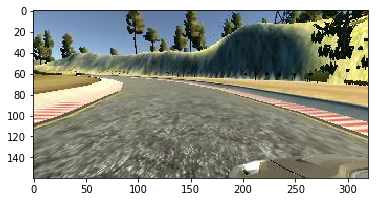

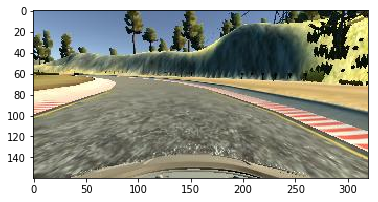

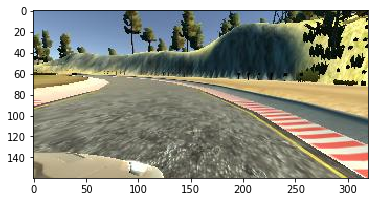

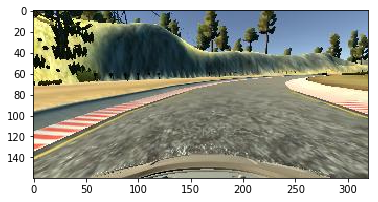

(4455,)


steer : -0.041176


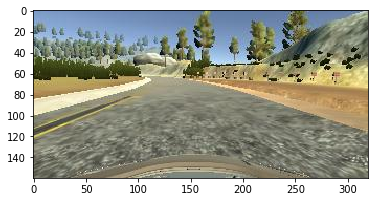



steer : 0.041176


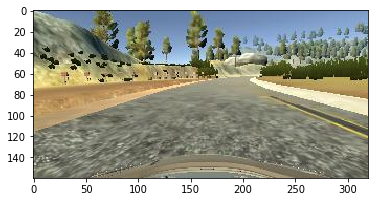

In [3]:
dataset_path = "../my_dataset/"
csv_path = dataset_path+ "driving_log.csv"

# read csv data

img_left=[]
img_center=[]
img_right=[]
steer=[]
with open(csv_path) as f:
    csv_data = list(csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONE, skipinitialspace=True))
    for row in csv_data:
        if(float(row[6])>1.0):     #remove start point
            img_center.append(row[0])
            img_left.append(row[1])
            img_right.append(row[2])
            steer.append(row[3])
#print wheel
num_data = len(img_center)
for i in range(num_data):
    filename = img_center[i].split('/')[-1]
    img_center[i]=dataset_path + "IMG/" + filename
    filename = img_left[i].split('/')[-1]
    img_left[i]=dataset_path + "IMG/" + filename
    filename = img_right[i].split('/')[-1]
    img_right[i]=dataset_path + "IMG/" + filename
   
_center = cv2.imread(img_center[0])
_left = cv2.imread(img_left[0])
_right = cv2.imread(img_right[0])

_left = cv2.cvtColor(_left, cv2.COLOR_BGR2RGB)
plt.imshow(_left)
plt.show()
_center = cv2.cvtColor(_center, cv2.COLOR_BGR2RGB)
plt.imshow(_center)
plt.show()
_right = cv2.cvtColor(_right, cv2.COLOR_BGR2RGB)
plt.imshow(_right)
plt.show()

_center_flip = cv2.flip(_center, 1)
plt.imshow(_center_flip)
plt.show()

print(np.shape(steer))
img_data_center=[]
img_label_center=np.asarray(steer, dtype='float32')
img_data_left=[]
img_label_left=np.asarray(steer, dtype='float32')+0.2
img_data_right=[]
img_label_right=np.asarray(steer, dtype='float32')-0.2
img_data_center_flip=[]
img_label_center_flip=np.asarray(steer, dtype='float32')*(-1.0)
img_data_left_flip=[]
img_label_left_flip=(np.asarray(steer, dtype='float32')+0.2)*(-1.0)
img_data_right_flip=[]
img_label_right_flip=(np.asarray(steer, dtype='float32')-0.2)*(-1.0)
for i in range(num_data):
    img = cv2.imread(img_center[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_data_center.append(img)
    img = cv2.flip(img, 1)
    img_data_center_flip.append(img)
    
    img = cv2.imread(img_left[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_data_left.append(img)
    img = cv2.flip(img, 1)
    img_data_left_flip.append(img)
    
    img = cv2.imread(img_right[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_data_right.append(img)
    img = cv2.flip(img, 1)
    img_data_right_flip.append(img)
    
print("\n\nsteer : %f"%img_label_center[100])
plt.imshow(img_data_center[100])
plt.show()
  
print("\n\nsteer : %f"%img_label_center_flip[100])
plt.imshow(img_data_center_flip[100])
plt.show()



In [6]:
import tensorflow as tf
import h5py
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D

input_shape=np.shape(img_data_center[0])
print(input_shape)

X_train = np.concatenate((img_data_center,img_data_center_flip, \
                          img_data_left, img_data_left_flip, \
                          img_data_right, img_data_right_flip ), axis=0)
y_train = np.concatenate((img_label_center,img_label_center_flip, \
                          img_label_left, img_label_left_flip, \
                          img_label_right, img_label_right_flip), axis=0)

base_depth = 24
addition = 12
model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=input_shape))  #(90, 320, 3)
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(base_depth           , 5, strides=(2,2))) #(43, 158)
model.add(Activation('relu'))
model.add(Convolution2D(base_depth+addition*1, 5, strides=(2,2))) 
model.add(Activation('relu'))
model.add(Convolution2D(base_depth+addition*2, 5, strides=(2,2))) 
model.add(Activation('relu'))
model.add(Convolution2D(base_depth+addition*3, 3)) 
model.add(Activation('relu'))
model.add(Convolution2D(base_depth+addition*4, 3)) 
model.add(Activation('relu'))
model.add(Convolution2D(base_depth+addition*5, 3)) 
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.05, shuffle=True, epochs=5)


model.save('model.h5')

(160, 320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_3 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 43, 158, 24)       1824      
_________________________________________________________________
activation_13 (Activation)   (None, 43, 158, 24)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 77, 36)        21636     
_________________________________________________________________
activation_14 (Activation)   (None, 20, 77, 36)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 37, 48)         43248  